## Домашнее задание №3

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Вернемся к задаче распознавания рукописных цифр, рассмотренной на первом занятии. Все также будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на пример, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Image label: 7')

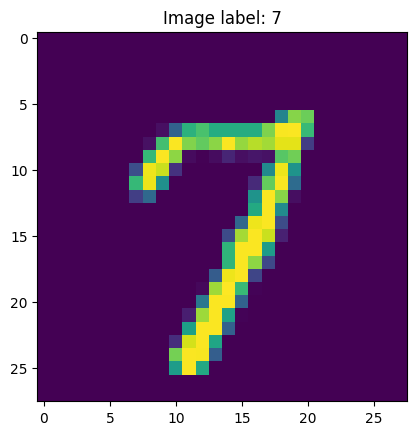

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
print(_image.size())
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [3]:
# Creating model instance
class Model(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, activation=torch.nn.ReLU):
        '''
        :param int in_features: Число входных признаков
        :param int hidden_size: Размер скрытых слоёв
        :param int n_classes: Число выходов сети
        :param int n_layers: Число слоёв в сети
        :param torch.nn.Module activation: Класс функции активации
        '''
        self.in_features = in_features
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.activation = activation
        super().__init__()
        self.layers = torch.nn.ModuleList([torch.nn.Linear(in_features, hidden_size)]+
         [torch.nn.Linear(hidden_size, hidden_size) for i in range(n_layers - 2)]+
          [torch.nn.Linear(hidden_size, n_classes)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Прямой проход по сети
        :param torch.Tensor x: Входной тензор размера [batch_size, in_features]
        :returns: Матрица логитов размера [batch_size, n_classes]
        '''
        ### your code here
        x = self.layers[0](x)
        x = self.activation().forward(x)
        for i in range(self.n_layers - 2):
          x = self.layers[1 + i](x)
          x = self.activation().forward(x)
        x = self.layers[-1](x)
        return x

model = Model(_image.size()[0]*_image.size()[1]*_image.size()[2], 256, 10, 3) # your code here

optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)

loss_fn = torch.nn.CrossEntropyLoss()

Локальные тесты для проверки вашей модели доступны ниже:

In [4]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784) # from matrix to vector
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. В качестве примера можете воспользоваться ноутбуком с занятия №1. Также рекомендуем поработать с различными оптимизаторами.

In [6]:
# your code here
from functools import partial

model.train()
for epoch in range(3):

  for im, lab in train_data_loader:
    im = im.view((32, -1))
    optimizer.zero_grad()
    y = model.forward(im)
    loss = loss_fn(y, lab)
    loss.backward()
    optimizer.step()
  print("loss:", loss)



loss: tensor(0.0882, grad_fn=<NllLossBackward0>)
loss: tensor(0.5030, grad_fn=<NllLossBackward0>)
loss: tensor(0.2301, grad_fn=<NllLossBackward0>)


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [7]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [8]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.93838


In [9]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [10]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9336


Проверка, что необходимые пороги пройдены:

In [11]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw03_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [12]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy

--2023-11-25 08:13:28--  https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw03_data_dict.npy’

hw03_data_dict.npy  100%[===================>]   5.98M  22.0MB/s    in 0.3s    

2023-11-25 08:13:29 (22.0 MB/s) - ‘hw03_data_dict.npy’ saved [6272438/6272438]



In [13]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw03_data_dict.npy'), 'Please, download `hw03_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw03_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw03.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw03.npy`')
# __________end of block__________

File saved to `submission_dict_hw03.npy`


На этом задание завершено. Поздравляем!